`1. Import Libraries & Read Data`

In [1]:
# Importing libraries
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Link to [Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

In [2]:
# Loading Training Data
training_dir = 'data/Training/'
training_paths = []
train_labels = []

for label in os.listdir(training_dir):
    label_dir = os.path.join(training_dir, label)
    if os.path.isdir(label_dir): 
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                training_paths.append(file_path)
                train_labels.append(label)

random.shuffle(training_paths)
random.shuffle(train_labels)

# show an example of the list
print(training_paths[0])

data/Training/meningioma/Tr-me_1242.jpg


In [3]:
# Loading Testing Data
test_dir = 'data/Testing/'
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir): 
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                test_paths.append(file_path)
                test_labels.append(label)

random.shuffle(test_paths)
random.shuffle(test_labels)

# show an example of the list
print(test_paths[0])

data/Testing/notumor/Te-no_0261.jpg


In [4]:
print(len(training_paths))
print(len(test_paths))

5712
1311


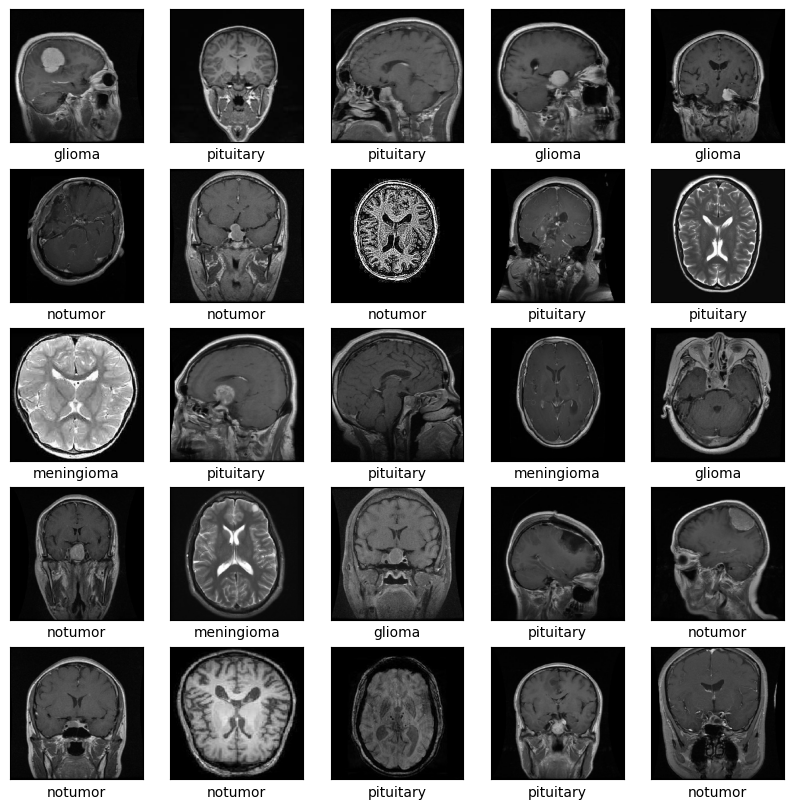

In [5]:
# View Images
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(training_paths[:25]):
    image = load_img(image_path, target_size=IMG_SIZE)  
    image = np.array(image)  
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image) 
    plt.xlabel(train_labels[i])
plt.show()

In [6]:
labels = [label for label in os.listdir(training_dir) if not label.startswith('.')]
labels

['pituitary', 'notumor', 'glioma', 'meningioma']

`2. Data Analysis`

In [7]:
# Getting Data Distribution
def count_images(directory):
    counts = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            counts[folder] = len([f for f in os.listdir(folder_path) if not f.startswith('.')])
    return counts

            Training Set  Testing Set
pituitary           1457          300
notumor             1595          405
glioma              1321          300
meningioma          1339          306


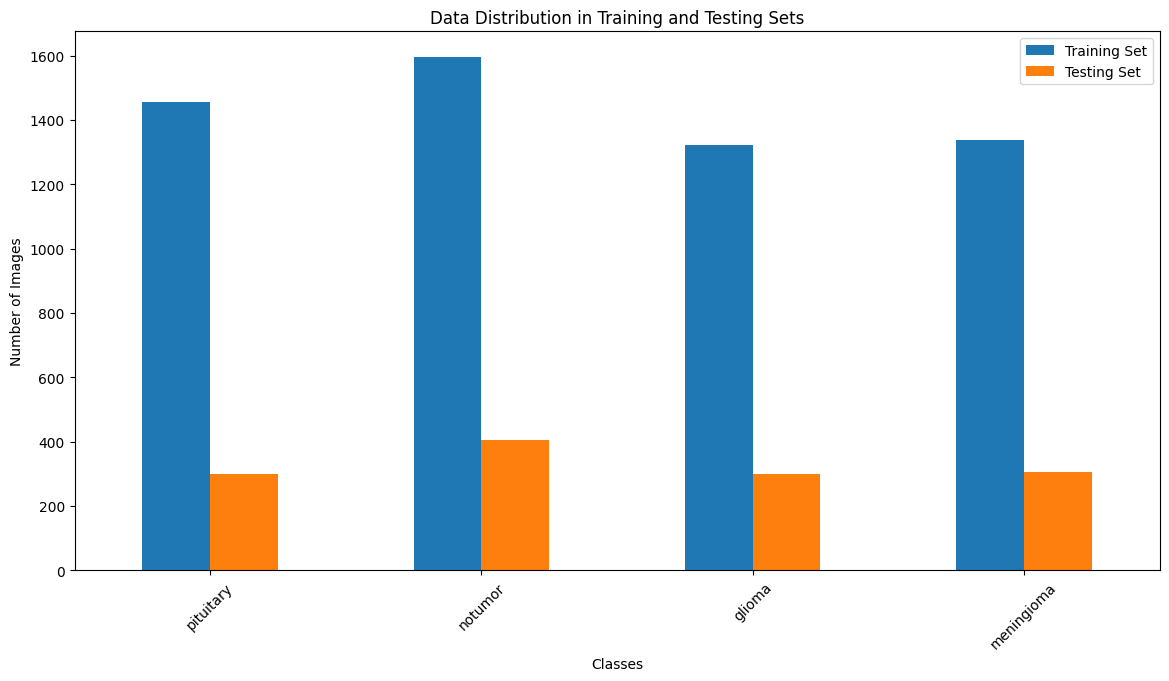

In [8]:
train_counts = count_images(training_dir)
test_counts = count_images(test_dir)

df = pd.DataFrame({
    'Training Set': train_counts,
    'Testing Set': test_counts
}).fillna(0).astype(int)

print(df)
df.plot(kind='bar', figsize=(14, 7))
plt.title('Data Distribution in Training and Testing Sets')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

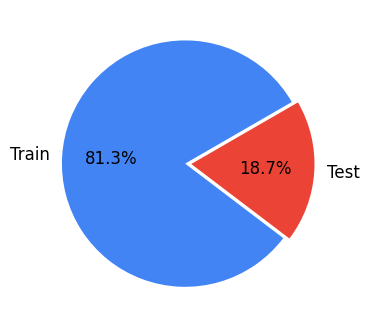

In [9]:
# Ratio of Training Data to Testing Data
plt.figure(figsize=(10,4))
colors = ['#4284f4', '#eb4335']
plt.rcParams.update({'font.size': 12})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

`3. Data Augmentation`

In [10]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=IMG_SIZE)
        image = image.convert('RGB')
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

In [11]:
# Data Generator
def data_gen(data_paths, batch_size=BATCH_SIZE):
    '''
    Given the image paths, it yields the images with the respective labels, as a batch
    '''
    while True:
        for i in range(0, len(data_paths), batch_size):
            paths = data_paths[i:i+batch_size]
            images = open_images(paths)
            labels = get_labels(paths)
            yield images, np.array(labels)

`4. Model Building, Transfer Learning`

In [12]:
# Loading the Pre-Trained Model (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape = (224,224,3), 
                                                include_top = False, 
                                                weights = 'imagenet' )
base_model.summary()

2024-06-17 16:25:45.215494: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-17 16:25:45.215517: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-17 16:25:45.215524: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-17 16:25:45.215963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-17 16:25:45.216353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [13]:
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
# Set the last block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [14]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Flatten, Dropout, Dense

model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                        

`5. Training the Model`

In [15]:
from tensorflow.keras.optimizers.legacy import Adam
tf.random.set_seed(42)
np.random.seed(42)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='sparse_categorical_crossentropy', 
                                metrics=['sparse_categorical_accuracy'])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
model_checkpoint = ModelCheckpoint(
    filepath='models/brain_weights.h5',
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
)

early_stopping = EarlyStopping(patience=3)

In [17]:
# Training the Model
history = model.fit(data_gen(training_paths), 
epochs=20,
steps_per_epoch=int(len(training_paths)/BATCH_SIZE), 
validation_data= data_gen(test_paths),
validation_steps=int(len(test_paths)/BATCH_SIZE),
callbacks=[early_stopping, model_checkpoint]

 )

Epoch 1/20


2024-06-17 16:25:48.896188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


178/178 [==============================] - ETA: 0s - loss: 0.9896 - sparse_categorical_accuracy: 0.8441

2024-06-17 16:26:09.005077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


178/178 [==============================] - 25s 98ms/step - loss: 0.9896 - sparse_categorical_accuracy: 0.8441 - val_loss: 0.4669 - val_sparse_categorical_accuracy: 0.8914
Epoch 2/20
178/178 [==============================] - 17s 91ms/step - loss: 0.1418 - sparse_categorical_accuracy: 0.9616 - val_loss: 0.4779 - val_sparse_categorical_accuracy: 0.8977
Epoch 3/20
178/178 [==============================] - 17s 95ms/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9880 - val_loss: 0.4049 - val_sparse_categorical_accuracy: 0.9015
Epoch 4/20
178/178 [==============================] - 18s 99ms/step - loss: 0.0113 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.3307 - val_sparse_categorical_accuracy: 0.9116
Epoch 5/20
178/178 [==============================] - 16s 92ms/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.2898 - val_sparse_categorical_accuracy: 0.9273
Epoch 6/20
178/178 [==============================] - 16s 92ms/step - loss: 0.0011 - sparse_categoric

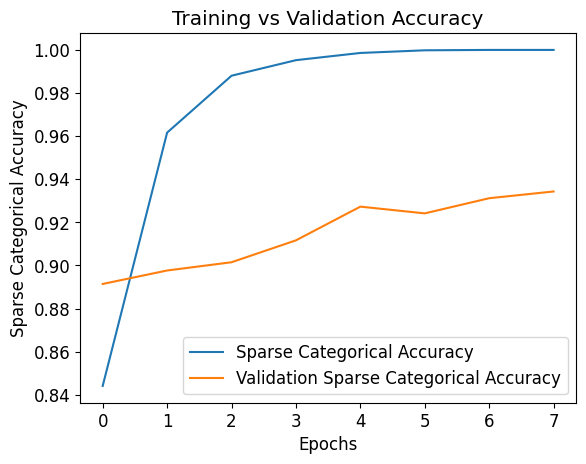

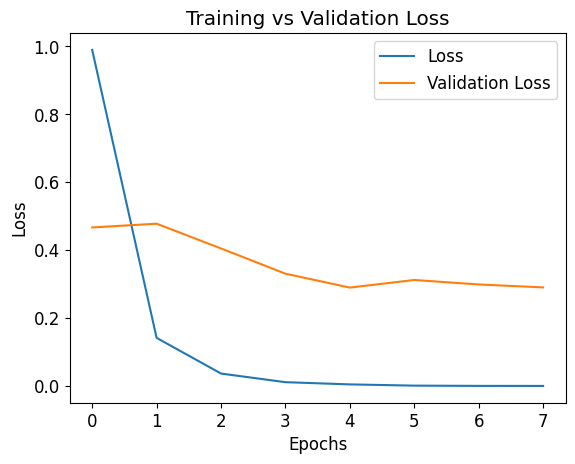

In [18]:
# Plot Training & Loss Graphs
def plot_graphs(history, string, title):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string.replace('_', ' ').title())
    plt.legend([string.replace('_', ' ').title(), 'Validation ' + string.replace('_', ' ').title()])
    plt.title(title)
    plt.show()

# Call the function with titles
plot_graphs(history, "sparse_categorical_accuracy", "Training vs Validation Accuracy")
plot_graphs(history, "loss", "Training vs Validation Loss")

In [19]:
model.save("model.h5")

/opt/miniconda3/envs/test/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Save model
model_json = model.to_json()
with open("models/brain_model.json", "w") as json_file:
    json_file.write(model_json)

`6. Model Evalaution`

In [21]:
# Load model for evaluation
from tensorflow.keras.models import model_from_json


with open("models/brain_model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("models/brain_weights.h5")

In [22]:
loaded_model.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='sparse_categorical_crossentropy', 
                                metrics=['sparse_categorical_accuracy'])

In [23]:
# Evaluation of Test Accuracy & Loss
steps = math.ceil(len(test_paths) / BATCH_SIZE)

evaluation = loaded_model.evaluate(data_gen(test_paths, batch_size=BATCH_SIZE), steps=steps)
print('Test Loss:', evaluation[0])
print('Test Accuracy:', evaluation[1])

2024-06-17 16:28:11.172560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 77ms/step - loss: 0.2994 - sparse_categorical_accuracy: 0.9329
Test Loss: 0.29940834641456604
Test Accuracy: 0.9328756928443909


In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# Classification Report
y_pred = loaded_model.predict(data_gen(test_paths, batch_size=BATCH_SIZE), steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.array(get_labels(test_paths))

target_names = labels
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=target_names))

2024-06-17 16:28:15.895817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 4s 67ms/step
Classification Report:
              precision    recall  f1-score   support

   pituitary       0.95      0.99      0.97       300
     notumor       0.97      0.98      0.97       405
      glioma       0.89      0.94      0.92       300
  meningioma       0.91      0.81      0.86       306

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



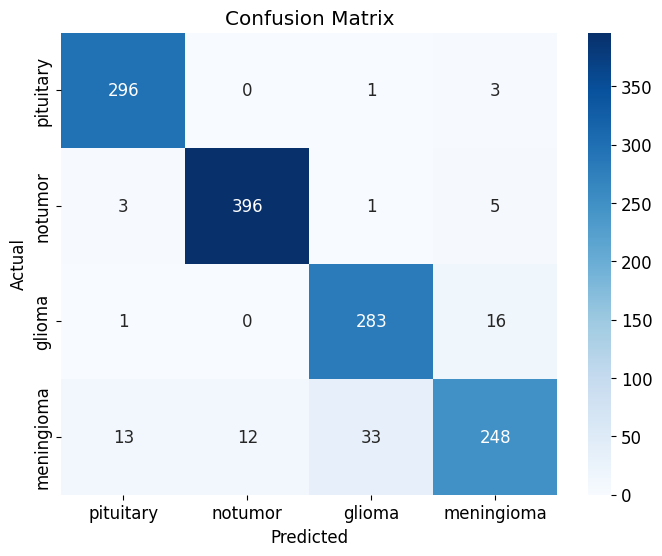

In [25]:
#Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

2024-06-17 16:28:19.682468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 969ms/step


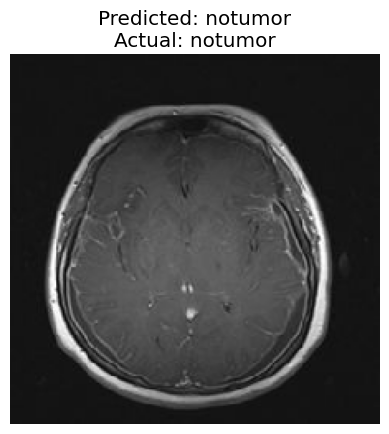

In [26]:
#Comparing Predicted vs Actual
i = random.randint(0, len(test_paths) - 1)

image_path = test_paths[i]
image = load_img(image_path, target_size=IMG_SIZE)
image_array = img_to_array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

predicted = loaded_model.predict(image_array)[0]
predicted_index = np.argmax(predicted)
predicted_label = labels[predicted_index]

actual_label = image_path.split('/')[-2]
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
plt.axis('off')
plt.show()